初始化环境

In [1]:
import findspark
findspark.init()

from pyspark.ml import Pipeline
from pyspark.sql import SparkSession # SparkSession 是Spark 2.0版本的新入口
spark = SparkSession.builder.master('local').getOrCreate()

# 加载 utils.py 中的自定义方法
from utils import *

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from time import time

训练集

In [6]:
col_names = ["duration","protocol_type","service","flag","src_bytes",
    "dst_bytes","land","wrong_fragment","urgent","hot","num_failed_logins",
    "logged_in","num_compromised","root_shell","su_attempted","num_root",
    "num_file_creations","num_shells","num_access_files","num_outbound_cmds",
    "is_host_login","is_guest_login","count","srv_count","serror_rate",
    "srv_serror_rate","rerror_rate","srv_rerror_rate","same_srv_rate",
    "diff_srv_rate","srv_diff_host_rate","dst_host_count","dst_host_srv_count",
    "dst_host_same_srv_rate","dst_host_diff_srv_rate","dst_host_same_src_port_rate",
    "dst_host_srv_diff_host_rate","dst_host_serror_rate","dst_host_srv_serror_rate",
    "dst_host_rerror_rate","dst_host_srv_rerror_rate","label"]
kdd_data_10percent = pd.read_csv("Data/kddcup.data_10_percent.gz", header=None, names = col_names)
kdd_data_10percent.describe()

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
count,494021.000000,4.940210e+05,4.940210e+05,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,...,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000
mean,47.979302,3.025610e+03,8.685324e+02,0.000045,0.006433,0.000014,0.034519,0.000152,0.148247,0.010212,...,232.470778,188.665670,0.753780,0.030906,0.601935,0.006684,0.176754,0.176443,0.058118,0.057412
std,707.746472,9.882181e+05,3.304000e+04,0.006673,0.134805,0.005510,0.782103,0.015520,0.355345,1.798326,...,64.745380,106.040437,0.410781,0.109259,0.481309,0.042133,0.380593,0.380919,0.230590,0.230140
min,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,4.500000e+01,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,255.000000,46.000000,0.410000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,5.200000e+02,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,255.000000,255.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,1.032000e+03,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,255.000000,255.000000,1.000000,0.040000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,58329.000000,6.933756e+08,5.155468e+06,1.000000,3.000000,3.000000,30.000000,5.000000,1.000000,884.000000,...,255.000000,255.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [7]:
# label 分布
kdd_data_10percent['label'].value_counts()

smurf.              280790
neptune.            107201
normal.              97278
back.                 2203
satan.                1589
ipsweep.              1247
portsweep.            1040
warezclient.          1020
teardrop.              979
pod.                   264
nmap.                  231
guess_passwd.           53
buffer_overflow.        30
land.                   21
warezmaster.            20
imap.                   12
rootkit.                10
loadmodule.              9
ftp_write.               8
multihop.                7
phf.                     4
perl.                    3
spy.                     2
Name: label, dtype: int64

In [9]:
major = attack2majorindex(kdd_data_10percent['label'])

from collections import Counter
major_dic = dict (Counter(major))

In [38]:
num = sum( major_dic.values())
for key,value in major_dic.items():
    print("%s \t %.2f %%"%(majorindex2string(key),value*100/num))

NORMAL 	 19.69 %
U2R 	 0.01 %
DOS 	 79.24 %
R2L 	 0.23 %
PROBE 	 0.83 %


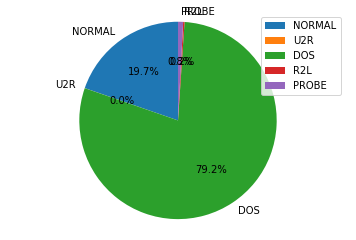

In [44]:
label_list = [majorindex2string(key) for key in major_dic.keys()]   # 各部分标签
size = major_dic.values()    # 各部分大小
patches, l_text, p_text = plt.pie(size,  labels=label_list, labeldistance=1.1, autopct="%1.1f%%", shadow=False, startangle=90, pctdistance=0.6)
plt.axis("equal")    # 设置横轴和纵轴大小相等，这样饼才是圆的
plt.legend()
plt.show()

验证集

In [45]:
corrected = pd.read_csv("Data/corrected.gz", header=None, names = col_names)
corrected.describe()

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
count,311029.000000,3.110290e+05,3.110290e+05,311029.000000,311029.000000,311029.000000,311029.000000,311029.000000,311029.000000,311029.000000,...,311029.000000,311029.000000,311029.000000,311029.000000,311029.000000,311029.000000,311029.000000,311029.000000,311029.000000,311029.000000
mean,17.902736,1.731702e+03,7.479937e+02,0.000029,0.000762,0.000051,0.014677,0.002363,0.172476,0.011243,...,235.282681,199.193914,0.793494,0.024953,0.547919,0.004566,0.058764,0.058791,0.142659,0.141693
std,407.644400,1.276567e+05,1.612018e+04,0.005379,0.040367,0.009821,0.312068,0.049990,0.377794,1.958325,...,60.913298,100.306470,0.387090,0.096003,0.491963,0.035773,0.231296,0.232997,0.344380,0.346573
min,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.050000e+02,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,255.000000,244.000000,0.970000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,5.200000e+02,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,255.000000,255.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,1.032000e+03,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,255.000000,255.000000,1.000000,0.010000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,57715.000000,6.282565e+07,5.203179e+06,1.000000,3.000000,3.000000,101.000000,4.000000,1.000000,796.000000,...,255.000000,255.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [48]:
corrected['label'].value_counts()

smurf.              164091
normal.              60593
neptune.             58001
snmpgetattack.        7741
mailbomb.             5000
guess_passwd.         4367
snmpguess.            2406
satan.                1633
warezmaster.          1602
back.                 1098
mscan.                1053
apache2.               794
processtable.          759
saint.                 736
portsweep.             354
ipsweep.               306
httptunnel.            158
pod.                    87
nmap.                   84
buffer_overflow.        22
multihop.               18
sendmail.               17
named.                  17
ps.                     16
rootkit.                13
xterm.                  13
teardrop.               12
land.                    9
xlock.                   9
xsnoop.                  4
ftp_write.               3
worm.                    2
perl.                    2
sqlattack.               2
loadmodule.              2
udpstorm.                2
phf.                     2
i

In [50]:
major = attack2majorindex(corrected['label'])

from collections import Counter
major_dic = dict (Counter(major))
num = sum( major_dic.values())
for key,value in major_dic.items():
    print("%s \t %.2f %%"%(majorindex2string(key),value*100/num))

NORMAL 	 19.48 %
R2L 	 5.20 %
DOS 	 73.90 %
PROBE 	 1.34 %
U2R 	 0.07 %


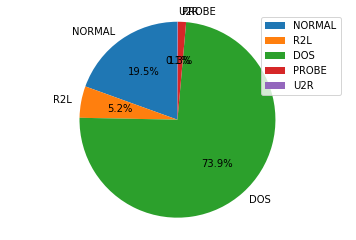

In [51]:
label_list = [majorindex2string(key) for key in major_dic.keys()]   # 各部分标签
size = major_dic.values()    # 各部分大小
patches, l_text, p_text = plt.pie(size,  labels=label_list, labeldistance=1.1, autopct="%1.1f%%", shadow=False, startangle=90, pctdistance=0.6)
plt.axis("equal")    # 设置横轴和纵轴大小相等，这样饼才是圆的
plt.legend()
plt.show()